In [30]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torch.nn as nn
from torchvision.transforms import v2
import multiprocessing
from torchtnt.utils.flops import FlopTensorDispatchMode
import copy
from codecarbon import EmissionsTracker

In [2]:
# device settings

num_workers = multiprocessing.cpu_count() // 2

print(torch.cuda.get_device_name(torch.cuda.current_device()))

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

AMD Radeon RX 7800 XT
Using cuda device


In [3]:
# define datasets and loaders

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_dataset = CIFAR10("./../data", train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=num_workers, drop_last=True)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [4]:
class BaseNN(nn.Module):
    def __init__(self, num_classes=10):
        super(BaseNN, self).__init__()
        self.features = nn.Sequential( # [3, 32, 32]
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1), # [32, 32, 32]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # [32, 16, 16]
            nn.Dropout(0.3),

            nn.Conv2d(32, 64, kernel_size=3, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), # [64, 16, 16]
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # [64, 8, 8]
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # [128, 8, 8]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # [128, 8, 8]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), # [128, 8, 8]
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2), # [128, 4, 4]
            nn.Dropout(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_base = BaseNN(num_classes=10).to(device)
model_base.load_state_dict(torch.load("../models/base2.pt"))

<All keys matched successfully>

In [7]:
class StudentNN(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model_student_self_taught = StudentNN(num_classes=10).to(device)
model_student_self_taught.load_state_dict(torch.load("../models/student_self_taught2.pt"))

model_student = StudentNN(num_classes=10).to(device)
model_student.load_state_dict(torch.load("../models/student2.pt"))

<All keys matched successfully>

In [34]:
def test(model):
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [53]:
emissionTracker = EmissionsTracker()
print("----------------------------------")

emissionTracker.start_task("Test teacher")
base_accuracy = test(model_base)
teacher_emissions = emissionTracker.stop_task()
print("----------------------------------")
emissionTracker.start_task("Test student")
student_accuracy = test(model_student)
student_emissions = emissionTracker.stop_task()
print("----------------------------------")
emissionTracker.start_task("Test self-taught student")
student_accuracy_self_taught = test(model_student_self_taught)
student_self_taught_emissions = emissionTracker.stop_task()

print("----------------------------------")
emissionTracker.stop()

[codecarbon WARNING @ 22:51:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 22:51:48] [setup] RAM Tracking...
[codecarbon INFO @ 22:51:48] [setup] CPU Tracking...
[codecarbon WARNING @ 22:51:48] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 22:51:48] CPU Model on constant consumption mode: AMD Ryzen 7 7800X3D 8-Core Processor
[codecarbon WARNING @ 22:51:48] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 22:51:48] [setup] GPU Tracking...
[codecarbon INFO @ 22:51:48] No GPU found.
[codecarbon INFO @ 22:51:48] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: Unspecified
            
[codecarbon INFO @ 22:51:48] >>>

----------------------------------


[codecarbon INFO @ 22:51:52] Energy consumed for RAM : 0.000005 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 22:51:53] Delta energy consumed for CPU with cpu_load : 0.000003 kWh, power : 12.0 W
[codecarbon INFO @ 22:51:53] Energy consumed for All CPU : 0.000003 kWh
[codecarbon INFO @ 22:51:53] 0.000008 kWh of electricity used since the beginning.


----------------------------------


[codecarbon INFO @ 22:51:54] Energy consumed for RAM : 0.000010 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 22:51:54] Delta energy consumed for CPU with cpu_load : 0.000003 kWh, power : 12.0 W
[codecarbon INFO @ 22:51:54] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 22:51:54] 0.000016 kWh of electricity used since the beginning.


----------------------------------


[codecarbon INFO @ 22:51:55] Energy consumed for RAM : 0.000015 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 22:51:56] Delta energy consumed for CPU with cpu_load : 0.000003 kWh, power : 12.0 W
[codecarbon INFO @ 22:51:56] Energy consumed for All CPU : 0.000009 kWh
[codecarbon INFO @ 22:51:56] 0.000024 kWh of electricity used since the beginning.
[codecarbon INFO @ 22:51:56] Energy consumed for RAM : 0.000015 kWh. RAM Power : 20.0 W


----------------------------------


[codecarbon INFO @ 22:51:56] Delta energy consumed for CPU with cpu_load : 0.000000 kWh, power : 12.0 W
[codecarbon INFO @ 22:51:56] Energy consumed for All CPU : 0.000009 kWh
[codecarbon INFO @ 22:51:56] 0.000024 kWh of electricity used since the beginning.
/home/carmel/.local/lib/python3.13/site-packages/codecarbon/output_methods/file.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_df], ignore_index=True)


1.5998936989485382e-05

In [32]:
print(f"Teacher test accuracy: {base_accuracy:.2f}%")
print(f"Student test accuracy: {student_accuracy:.2f}%")
print(f"Self-taught student test accuracy: {student_accuracy_self_taught:.2f}%")

Teacher test accuracy: 80.62%
Student test accuracy: 77.06%
Self-taught student test accuracy: 73.91%


In [59]:
print("Measurements for 10,000 predictions")
print("-----------------------------------")

print(f"Teacher: \n- energy consumed - {teacher_emissions.energy_consumed}\n- rate of emissions - {teacher_emissions.emissions_rate}\n- duration - {teacher_emissions.duration}\n- emissions - {teacher_emissions.emissions}\n")
print(f"Student: \n- energy consumed - {student_emissions.energy_consumed}\n- rate of emissions - {student_emissions.emissions_rate}\n- duration - {student_emissions.duration}\n- emissions - {student_emissions.emissions}\n")
print(f"Self-taught student: \n- energy consumed - {student_self_taught_emissions.energy_consumed}\n- rate of emissions - {student_self_taught_emissions.emissions_rate}\n- duration - {student_self_taught_emissions.duration}\n- emissions - {student_self_taught_emissions.emissions}")

Measurements for 10,000 predictions
-----------------------------------
Teacher: 
- energy consumed - 8.3338819100148e-06
- rate of emissions - 5.875213448255578e-06
- duration - 0.9395963440001651
- emissions - 5.5164131171684565e-06

Student: 
- energy consumed - 7.894639416667312e-06
- rate of emissions - 5.8757233414806414e-06
- duration - 0.8896951120004815
- emissions - 5.225667090516928e-06

Self-taught student: 
- energy consumed - 7.929703207777895e-06
- rate of emissions - 5.8761205322256274e-06
- duration - 0.8933965029973479
- emissions - 5.248876725511589e-06


In [10]:
print(f'distillation accuracy change: {(student_accuracy - base_accuracy):.2f}%')


distillation accuracy change: -3.56%


In [11]:
print(f'Teacher size: {os.path.getsize('../models/base2.pt')/(1024*1024):.2f} MB')
print(f'Student size: {os.path.getsize('../models/student2.pt')/(1024*1024):.2f} MB')
print(f'Self-taught student size: {os.path.getsize('../models/student_self_taught2.pt')/(1024*1024):.2f} MB')

Teacher size: 3.67 MB
Student size: 0.60 MB
Self-taught student size: 0.60 MB


In [12]:
def plot_confusion_matrix(model):
    confusion_matrix = np.zeros((10, 10), dtype=int)

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
        
        outputs = np.argmax(outputs.cpu().detach().numpy(), axis=1)
        confusion_matrix = np.add(confusion_matrix, sklearn.metrics.confusion_matrix(labels.cpu(), outputs))

    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

    plt.show()

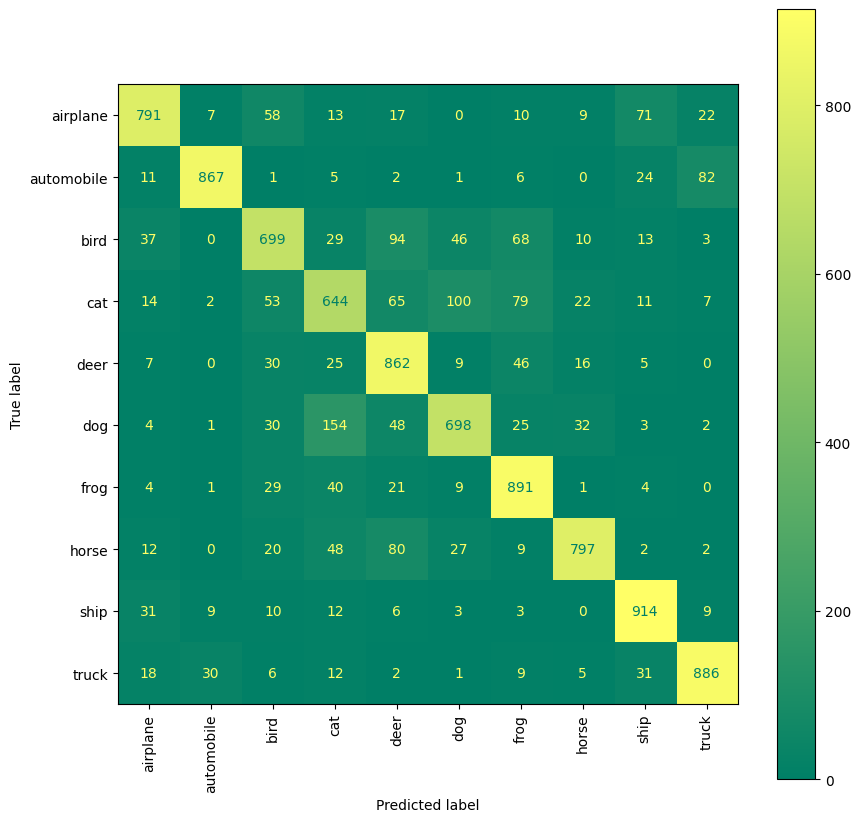

In [13]:
plot_confusion_matrix(model_base)

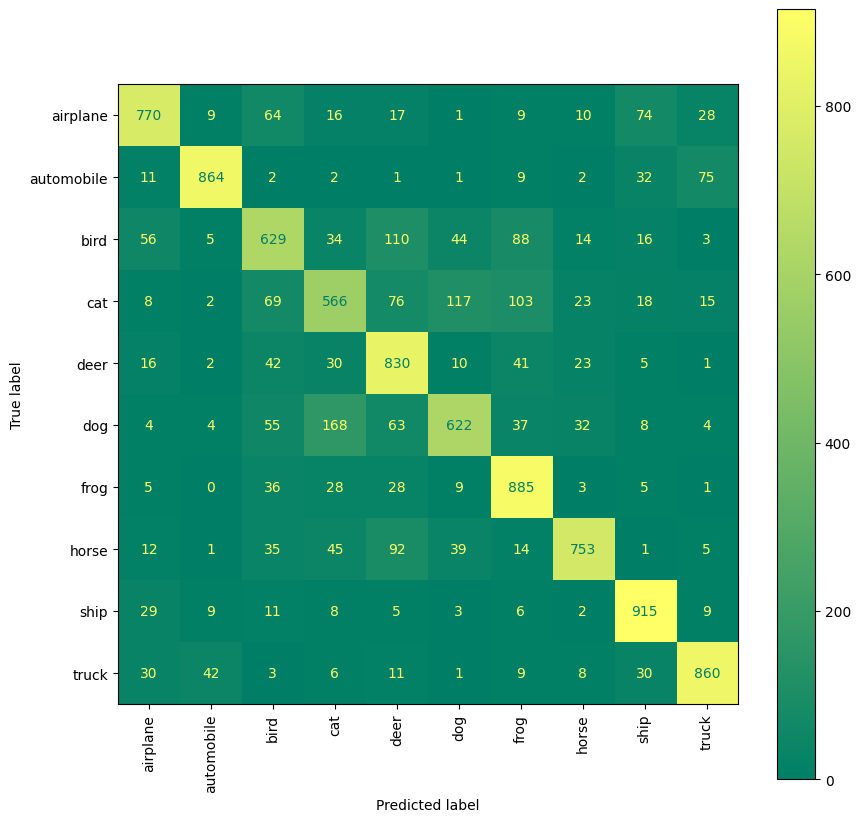

In [14]:
plot_confusion_matrix(model_student)

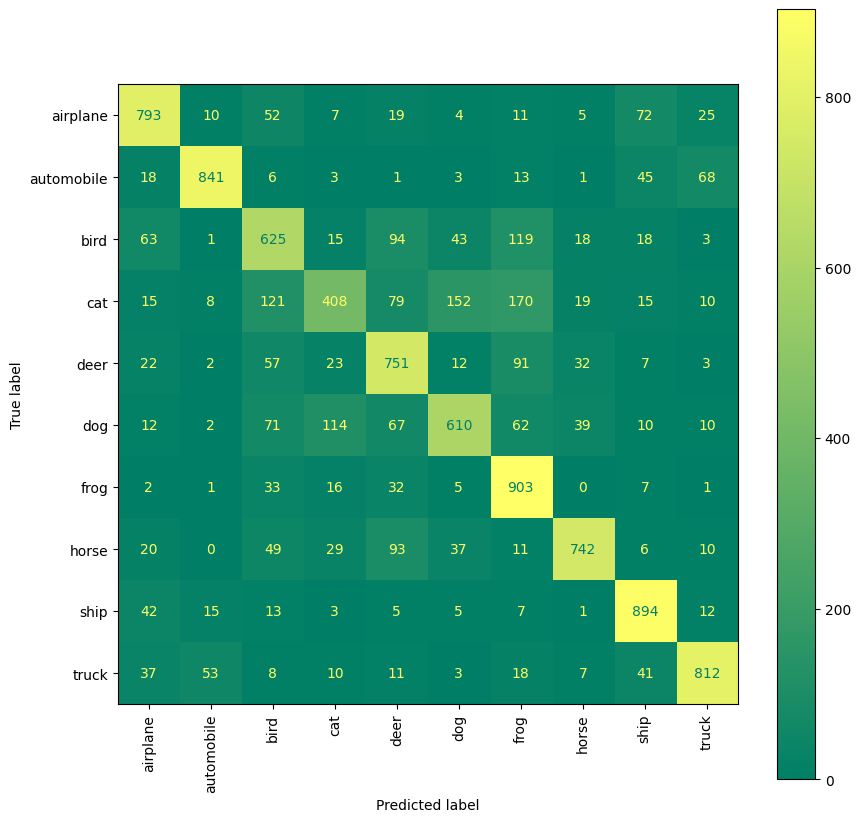

In [15]:
plot_confusion_matrix(model_student_self_taught)

In [ ]:
def print_pretty_flops(flop_counts, title):
    total_flops = 0
    for module_name in flop_counts.keys():
        operations = flop_counts[module_name]
        module_total = sum(operations.values())
        total_flops += module_total

    print(f"Total {title}: {total_flops:,.0f}")


def get_flops(model, random_input, name):
    with FlopTensorDispatchMode(model) as ftdm:
        # count forward flops
        res = model(random_input).mean()
        flops_forward = copy.deepcopy(ftdm.flop_counts)

        # reset count before counting backward flops
        ftdm.reset()
        res.backward()
        flops_backward = copy.deepcopy(ftdm.flop_counts)

        print_pretty_flops(flops_forward, "Forward FLOPS - " + name)
        print_pretty_flops(flops_backward, "Backward FLOPS - " + name)

random_input = torch.randn(1, 3, 32, 32).to(device)

get_flops(model_base, random_input, "Teacher")
get_flops(model_student, random_input, "Student")
get_flops(model_student_self_taught, random_input, "Self-taught student")

Total Forward FLOPS - Teacher: 145,792,512
Total Backward FLOPS - Teacher: 288,930,816
Total Forward FLOPS - Student: 8,802,048
Total Backward FLOPS - Student: 16,276,992
Total Forward FLOPS - Self-taught student: 8,802,048
Total Backward FLOPS - Self-taught student: 16,276,992
